In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
def compute_ssim(arr1, arr2):
    """
    Compute the Structural Similarity Index between two arrays.
    """
    # Ensure the arrays are of the same shape
    x = min(arr1.shape[0], arr2.shape[0])
    y = min(arr1.shape[1], arr2.shape[1])

    arr1_cropped = arr1[:x, :y]
    arr2_cropped = arr2[:x, :y]

    # Compute SSIM
    ssim_value, _ = ssim(arr1_cropped, arr2_cropped, full=True)
    return ssim_value

In [3]:
def apply_rotation(angle, img):
    """
    Rotate the image using OpenCV
    """
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows))

In [4]:
def find_best_angle(static, moving, angle_range):
    return max(angle_range, key=lambda angle: compute_ssim(static, apply_rotation(angle, moving)))

In [5]:
def adaptive_angle_search(static, moving, initial_range=(-180, 180), precision=0.1):
    current_range = initial_range
    while current_range[1] - current_range[0] > precision:
        angles = np.linspace(current_range[0], current_range[1], 20)
        best_angle = find_best_angle(static, moving, angles)
        range_width = (current_range[1] - current_range[0]) / 4
        current_range = (max(best_angle - range_width, initial_range[0]), 
                         min(best_angle + range_width, initial_range[1]))
    return find_best_angle(static, moving, np.linspace(current_range[0], current_range[1], 20))

In [6]:
# Load images
static = cv2.imread('brain.png', cv2.IMREAD_GRAYSCALE)
moving = cv2.imread('distorted.png', cv2.IMREAD_GRAYSCALE)

# Ensure the images are loaded properly
if static is None or moving is None:
    raise ValueError("One or both images could not be loaded.")

In [7]:
# Find best angle
best_angle = adaptive_angle_search(static, moving)

# Apply rotation
transformed = apply_rotation(best_angle, moving)

In [8]:
# Calculate SSIM
initial_ssim = compute_ssim(static, moving)
final_ssim = compute_ssim(static, transformed)

Best angle: 20.00
Initial SSIM: 0.6278
Final SSIM: 0.9863


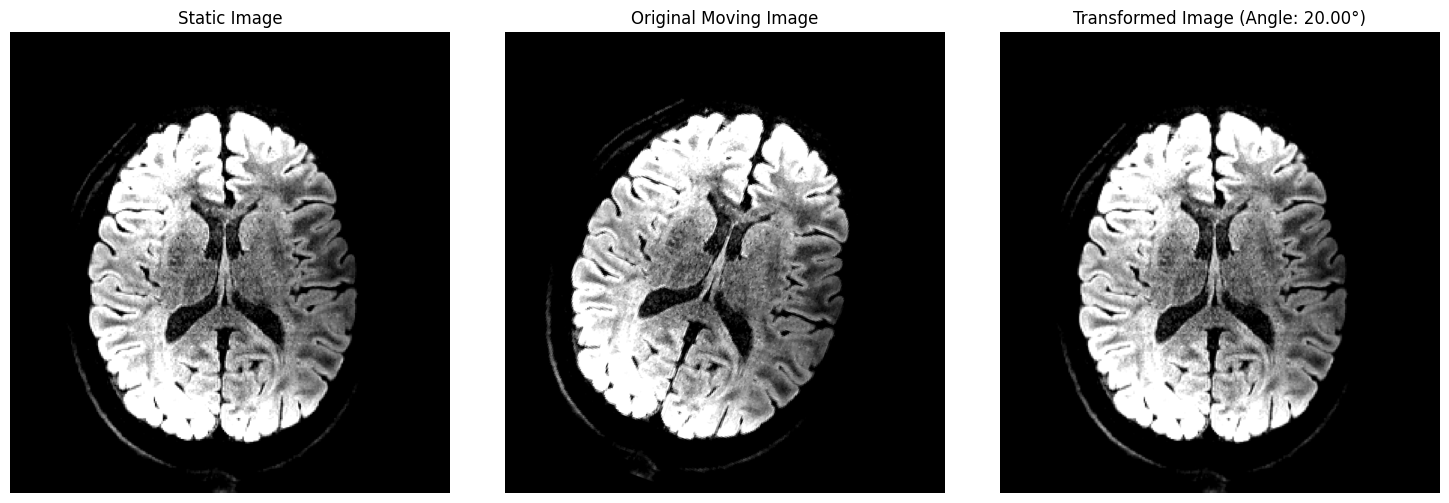

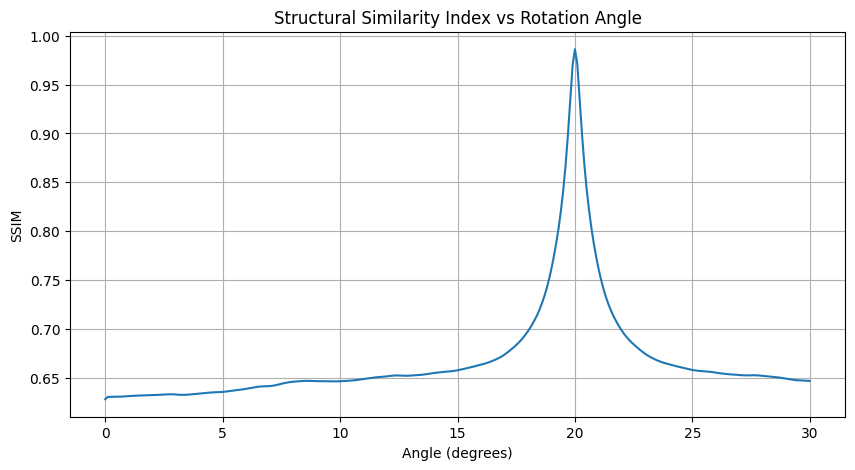

In [9]:
# Display results
print(f"Best angle: {best_angle:.2f}")
print(f"Initial SSIM: {initial_ssim:.4f}")
print(f"Final SSIM: {final_ssim:.4f}")

def plot_three_images(img1, img2, img3, title1, title2, title3):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap='gray')
    plt.title(title3)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the static, original moving, and transformed images
plot_three_images(static, moving, transformed, 
                  'Static Image', 'Original Moving Image', 
                  f'Transformed Image (Angle: {best_angle:.2f}°)')

# Plot SSIM vs Angle
angles = np.linspace(0, 30, 301)
ssim_values = [compute_ssim(static, apply_rotation(angle, moving)) for angle in angles]
plt.figure(figsize=(10, 5))
plt.plot(angles, ssim_values)
plt.title('Structural Similarity Index vs Rotation Angle')
plt.xlabel('Angle (degrees)')
plt.ylabel('SSIM')
plt.grid(True)
plt.show()